# Tutorial de Classificação com Texto

Na última aula, vimos como aplicar a regressão logística para a classificação com dados quantitativos. Agora, vamos trabalhar uma classificação de textos utilizando regressão logística. Antes que façam a classificação, precisamos introduzir duas coisas importantes: Pré-processamento de texto e a bag-of-words em Python. Vamos importar alguns pacotes importantes

In [1]:
from sklearn.linear_model import LogisticRegression # Modelo de regressão logística do sklearn
from sklearn.model_selection import train_test_split # Função para dividir o banco entre treino e teste
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Algumas métricas e relatórios

Vamos também importar nosso banco de dados final do Github do NUPRAM

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


url = "https://github.com/NUPRAM/CoViD-Pol/raw/main/Covid-Pol_Corpus_v2.0.csv"

# Carrega o arquivo Excel em um DataFrame
df_ex = pd.read_csv(url)

df_ex.head()

,Unnamed: 0,id,tweet_id,post_date,content,relevant,final_stance,final_sentiment,final_children
0,0,523,A522,2020-09-15,A cabeça pensa onde o pé pisa. Quem governa de...,True,favorable,negative,true
1,1,458,A457,2020-11-20,Sarto vai fazer um grande Programa de Enfrenta...,True,favorable,positive,false
2,2,446,A445,2020-12-18,A Câmara dos Deputados votou hoje a MP que tra...,True,favorable,negative,false
3,3,547,A546,2020-11-10,Tirar Bolsonaro do poder é uma questão de vida...,True,favorable,negative,false
4,4,848,A847,2020-09-24,E a LIESA decidiu adiar os desfiles do #Carnav...,True,favorable,negative,false


#### Pré-processamento de texto

O pré-processamento de texto desempenha um papel crítico no campo de aprendizado de máquina quando você está trabalhando com dados de texto. Essa etapa é fundamental para garantir que os dados de texto estejam em um formato adequado para serem usados eficazmente em algoritmos de aprendizado de máquina. Aqui estão algumas das razões pelas quais o pré-processamento de texto é importante:

* Padronização de Dados: Os dados de texto podem ser altamente variáveis, com diferenças na grafia, formatação, capitalização e pontuação. O pré-processamento ajuda a padronizar os dados, tornando-os consistentes e facilitando o trabalho com eles.

* Remoção de Ruídos: Os textos frequentemente contêm informações irrelevantes ou ruídos, como caracteres especiais, números de telefone, URLs, marcações HTML e muito mais. O pré-processamento pode ajudar a remover esses ruídos, concentrando-se nas informações textuais essenciais.

* Tokenização: A tokenização é o processo de dividir o texto em unidades menores, chamadas tokens, que geralmente são palavras ou grupos de palavras. Isso é importante para que o modelo possa entender o texto em nível de palavra.

* Remoção de Stop Words: As "stop words" são palavras comuns, como "a", "o", "de", que não contribuem muito para o significado do texto e podem ser removidas para reduzir a dimensionalidade e a intensidade computacional.

Vamos trabalhar com um tweet aleatório como exemplo:

In [3]:
import random

random.seed(66) # estabilizando a aleatoriedade

# Primeiro, obtenha o número total de tweets no DataFrame
total_tweets = len(df_ex)

# Em seguida, gere um índice aleatório entre 0 e o número total de tweets - 1
indice_aleatorio = random.randint(0, total_tweets - 1)

# Agora, extraia o tweet correspondente ao índice aleatório
tweet_aleatorio = df_ex.loc[indice_aleatorio, 'content']

# Exiba o tweet aleatório
print(tweet_aleatorio)

Para nós não importa se será chinesa, russa, americana ou européia, tem quer usada desde que demonstre sua eficácia contra a coronavírus. Não podemos fazer disso uma guerra política. Mais de 88% dos brasileiros querem a vacina e destacam sua importância contra as doenças.


Vamos fazer um pré-processamento simples neste tweets. Primeiro, vamos remover os links ao final (Nesse exemplo não tem, mas esse código remove):

In [4]:
import re # Biblioteca de regular expressions


# Use uma expressão regular para encontrar e remover URLs
tweet_sem_links = re.sub(r'https://\S+', '', tweet_aleatorio)

print(tweet_sem_links)

Para nós não importa se será chinesa, russa, americana ou européia, tem quer usada desde que demonstre sua eficácia contra a coronavírus. Não podemos fazer disso uma guerra política. Mais de 88% dos brasileiros querem a vacina e destacam sua importância contra as doenças.


Agora, vamos remover as quebras de linha ('\n')

In [5]:
tweet_sem_quebra_de_linha = tweet_sem_links.replace('\\n', ' ') # Para remover algo com \, precisamos adicionar duas barras

print(tweet_sem_quebra_de_linha)

Para nós não importa se será chinesa, russa, americana ou européia, tem quer usada desde que demonstre sua eficácia contra a coronavírus. Não podemos fazer disso uma guerra política. Mais de 88% dos brasileiros querem a vacina e destacam sua importância contra as doenças.


Agora, as hashtags

In [6]:
# Use uma expressão regular para encontrar hashtags e preservar o texto associado
tweet_sem_hashtags = re.sub(r'#(\w+)', r'\1', tweet_sem_quebra_de_linha)


print(tweet_sem_hashtags)

Para nós não importa se será chinesa, russa, americana ou européia, tem quer usada desde que demonstre sua eficácia contra a coronavírus. Não podemos fazer disso uma guerra política. Mais de 88% dos brasileiros querem a vacina e destacam sua importância contra as doenças.


Agora, podemos aplicar alguns dos pré-processamentos que são comuns a todos os textos, não só à tweets:

In [7]:
# Deixar todas as letras minúsculas
tweet_min = tweet_sem_hashtags.lower()


#seleciona apenas letras (lembrando que o texto está em português e as letras possuem acento)
apenas_letras = re.findall(r'[a-zíéóáêâãõç]+', tweet_min)


# Juntar o texto, já que o .findall separa em tokens
tweet_final = " ".join(apenas_letras)

# Resultado final
print(tweet_final)

para nós não importa se será chinesa russa americana ou européia tem quer usada desde que demonstre sua eficácia contra a coronavírus não podemos fazer disso uma guerra política mais de dos brasileiros querem a vacina e destacam sua importância contra as doenças


Então, dividimos o texto em tokens (pequenos pedaços) e geramos o vocabulário

In [8]:
from nltk import word_tokenize # Tokenizador do nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Tokenizando o tweet
tokens = word_tokenize(tweet_final)

tokens

['para',
 'nós',
 'não',
 'importa',
 'se',
 'será',
 'chinesa',
 'russa',
 'americana',
 'ou',
 'européia',
 'tem',
 'quer',
 'usada',
 'desde',
 'que',
 'demonstre',
 'sua',
 'eficácia',
 'contra',
 'a',
 'coronavírus',
 'não',
 'podemos',
 'fazer',
 'disso',
 'uma',
 'guerra',
 'política',
 'mais',
 'de',
 'dos',
 'brasileiros',
 'querem',
 'a',
 'vacina',
 'e',
 'destacam',
 'sua',
 'importância',
 'contra',
 'as',
 'doenças']

**Gerando o vocabulário**

Gerar o vocabulário é uma etapa importante no processamento de linguagem natural (PLN) e, mais especificamente, na criação de modelos de "Bag-of-Words" (BoW) ou "Term Frequency-Inverse Document Frequency" (TF-IDF) para análise de texto. Essa etapa envolve a identificação e criação de um conjunto de todas as palavras únicas (types) que aparecem em um conjunto de documentos, como um corpus ou conjunto de textos. Isso significa que cada palavra diferente, independentemente de quantas vezes ela ocorra, é considerada uma única entrada no vocabulário.



In [10]:
# Gerando o vocabulário
Vocab = []
for token in tokens:
    if token not in Vocab:
        Vocab.append(token)

print(Vocab,"\n",len(Vocab))

['para', 'nós', 'não', 'importa', 'se', 'será', 'chinesa', 'russa', 'americana', 'ou', 'européia', 'tem', 'quer', 'usada', 'desde', 'que', 'demonstre', 'sua', 'eficácia', 'contra', 'a', 'coronavírus', 'podemos', 'fazer', 'disso', 'uma', 'guerra', 'política', 'mais', 'de', 'dos', 'brasileiros', 'querem', 'vacina', 'e', 'destacam', 'importância', 'as', 'doenças'] 
 39


#### Bag of Words

O "Bag-of-Words" (BoW), em português "Saco de Palavras", é uma técnica fundamental de processamento de linguagem natural (PLN) e análise de texto. Essa abordagem é usada para representar e analisar documentos de texto, transformando-os em uma estrutura numérica que pode ser utilizada por algoritmos de aprendizado de máquina e outras técnicas de análise de dados. Aqui está uma explicação do conceito de BoW:

Definição Básica:

O BoW é uma representação simplificada de um documento de texto que ignora a estrutura gramatical e a ordem das palavras, tratando o texto como uma "sacola" (bag) de palavras.

Processo de Criação:

* Para criar um BoW de um documento, você primeiro tokeniza o texto, dividindo-o em palavras ou termos individuais.

* Em seguida, você cria um vocabulário, que é uma lista de todas as palavras únicas encontradas em um conjunto de documentos (um corpus). Cada palavra única é considerada um "token."

* Para cada documento, você cria um vetor numérico que representa a frequência ou a presença/ausência de cada palavra do vocabulário no documento.

**Representação Numérica**:

Existem duas maneiras comuns de representar numericamente um BoW:

* Contagem de Frequência (CountVectorizer): Nesta abordagem, cada elemento do vetor representa a contagem de quantas vezes uma palavra específica aparece no documento. Por exemplo, se o vocabulário contém as palavras ["gato", "cachorro", "rápido"], e o documento é "O gato é rápido", o vetor BoW seria [1, 0, 1].

* Binário (BinaryVectorizer): Nesta abordagem, cada elemento do vetor é 1 se a palavra está presente no documento e 0 caso contrário. No exemplo anterior, o vetor BoW seria [1, 0, 1], pois "gato" e "rápido" estão presentes, mas "cachorro" não está.

**Usos do BoW**:

O BoW é amplamente usado em tarefas de processamento de texto, como classificação de texto, agrupamento de documentos, recuperação de informações, análise de sentimentos e muito mais.

Também é usado como entrada para algoritmos de aprendizado de máquina, como na Regressão Logística, Naive Bayes e máquinas de vetores de suporte (SVM), que não podem trabalhar diretamente com texto, mas podem usar a representação numérica do BoW.

**Limitações do BoW**:

* O BoW perde informações importantes sobre a ordem das palavras e a estrutura gramatical do texto.

* Não leva em consideração a semântica das palavras; palavras diferentes com significados semelhantes são tratadas como distintas.

* O tamanho do vetor BoW pode ser grande, especialmente em grandes vocabulários, levando a problemas de dimensionalidade (muitas células vazias nas colunas).

* Não lida bem com palavras raras ou específicas do contexto, que podem ser ignoradas ou tratadas como irrelevantes.

Apesar de suas limitações, o BoW é uma técnica valiosa para muitas aplicações de PLN e análise de texto, especialmente quando a ordem das palavras não é crítica e a representação simples de frequência de palavras é suficiente para a tarefa em questão.

Vamos pegar os dois primeiros tweets do banco para vocês terem uma noção de como funciona. Vamos também limpar o banco de stopwords.

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Vinte primeiras stopwords do português no nltk

In [12]:
stopwords.words('portuguese')[:20]

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele']

Vamos utilizar esta lista de stopwords para reduzir a dimensionalidade do nosso banco de dados.

In [13]:
# Definindo o dicionário de stop_words
stop_words = stopwords.words('portuguese')

# Importando o Vetorizador do sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Criando o vetorizador, utilizando nossa lista de stop_words
vectorizer = CountVectorizer(stop_words=stop_words,
                             ngram_range=(1,1)) # Palavras serão tratadas individualmente (ngram = 1)

# Transformando as duas primeiras observações da coluna de texto em BOW
X = vectorizer.fit_transform(df_ex['content'].head(2))

print(X.toarray())

[[1 1 1 1 0 1 0 1 1 0 1 2 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1
  1 0 0 1 0 0 0 1 1]
 [0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 2 0 0
  0 1 1 0 1 1 2 0 0]]


In [14]:
df_bow_sklearn = pd.DataFrame(X.toarray())
df_bow_sklearn.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1,1,1,1,0,1,0,1,1,0,...,1,1,0,0,1,0,0,0,1,1
1,0,0,0,0,1,0,1,0,0,1,...,0,0,1,1,0,1,1,2,0,0


Vemos que, só para esses dois tweets, temos muitas colunas representando cada palavra e a contagem da frequência delas. Por exemplo, para a palavra 0, ela aparece 1 vez no primeiro tweet (linha 0), e zero vezes no tweet 2 (linha 1). Aqui, podemos ver também por que a dimensionalidade pode ser um problema na bag-of-words: Com apenas dois tweets, chegamos em 45 colunas. Com um banco de tweets maior com maior variedade de palavras e vocabulário, o Bag-of-Words pode se tornar gigantesco.

#### Processando nossa coluna de texto

Passamos por alguns exemplos individuais só para que vocês entendessem por cima como funciona o pré-processamento do texto e sua posterior transformação em uma Bag-of-Words. Vamos fazer o mesmo e treinar o modelo utilizando o banco completo. Primeiro, vamos remover os tweets que não são relacionados às vacinas.

In [15]:
df_ex.head(3)

,Unnamed: 0,id,tweet_id,post_date,content,relevant,final_stance,final_sentiment,final_children
0,0,523,A522,2020-09-15,A cabeça pensa onde o pé pisa. Quem governa de...,True,favorable,negative,true
1,1,458,A457,2020-11-20,Sarto vai fazer um grande Programa de Enfrenta...,True,favorable,positive,false
2,2,446,A445,2020-12-18,A Câmara dos Deputados votou hoje a MP que tra...,True,favorable,negative,false


In [16]:
df_ex2 = df_ex[df_ex['relevant'] == True].reset_index()

df_ex2.head(3)

,index,Unnamed: 0,id,tweet_id,post_date,content,relevant,final_stance,final_sentiment,final_children
0,0,0,523,A522,2020-09-15,A cabeça pensa onde o pé pisa. Quem governa de...,True,favorable,negative,true
1,1,1,458,A457,2020-11-20,Sarto vai fazer um grande Programa de Enfrenta...,True,favorable,positive,false
2,2,2,446,A445,2020-12-18,A Câmara dos Deputados votou hoje a MP que tra...,True,favorable,negative,false


Vamos ver como ficou a distribuição das classes de posicionamento

In [17]:
df_ex2['final_stance'].value_counts()

,count
final_stance,
favorable,4645
unclear,1065
unfavorable,236


Vamos transformar a coluna de posicionamento em uma coluna de apenas duas classes, juntando favoráveis e unclear.

In [18]:
# Por fim, vamos criar uma condição que transforma a tarefa de classificação em uma classificação binária.

def condicao(x):
    if x == 'favorable':
        return 0 # Favorável = 0
    elif x == 'unclear':
        return 0 # Unclear também = 0
    else:
        return 1


df_ex2['final_stance_dummy'] = df_ex2['final_stance'].apply(condicao)


# Imprimindo o banco final

df_ex2.head(3)


,index,Unnamed: 0,id,tweet_id,post_date,content,relevant,final_stance,final_sentiment,final_children,final_stance_dummy
0,0,0,523,A522,2020-09-15,A cabeça pensa onde o pé pisa. Quem governa de...,True,favorable,negative,true,0
1,1,1,458,A457,2020-11-20,Sarto vai fazer um grande Programa de Enfrenta...,True,favorable,positive,false,0
2,2,2,446,A445,2020-12-18,A Câmara dos Deputados votou hoje a MP que tra...,True,favorable,negative,false,0


Checando o resultado

In [19]:
df_ex2['final_stance_dummy'].value_counts()

,count
final_stance_dummy,
0,5710
1,252


Agora, vamos criar uma nova coluna de texto pré-processada como fizemos anteriormente.

In [20]:
# Criando uma função de pré-processamento

def preprocess_text(texto):
    # Use uma expressão regular para encontrar e remover URLs
    texto = re.sub(r'https://\S+', '', texto)

    # Remover quebra de linha
    texto = texto.replace('\\n', ' ')

    # Remover Hashtags
    texto = re.sub(r'#(\w+)', r'\1', texto)

    # Deixar todas as letras minúsculas
    texto = texto.lower()

    # Selecionar apenas letras
    texto = re.findall(r'[a-zéóáêâãõç]+', texto)

    # Juntar o texto, já que o .findall separa em tokens
    texto = " ".join(texto)

    return texto

# Criando a nova coluna transformada
df_ex2["texto_processado"] = df_ex2['content'].apply(preprocess_text)

pd.set_option('display.max_colwidth', None) # Para mostrar a coluna inteira

# Imprimindo
df_ex2[['content','texto_processado']]

,content,texto_processado
0,"A cabeça pensa onde o pé pisa. Quem governa de dentro do escritório com ar-condicionado não conhece o dia-a-dia das escolas em POA. O protocolo de volta às aulas de Marchezan, como diz @ProfAlexFraga, é miserável e coloca a vida de alunos e professores em risco. #SemVacinaSemAula",a cabeça pensa onde o pé pisa quem governa de dentro do escritório com ar condicionado não conhece o dia a dia das escolas em poa o protocolo de volta s aulas de marchezan como diz profalexfraga é miserável e coloca a vida de alunos e professores em risco semvacinasemaula
1,"Sarto vai fazer um grande Programa de Enfrentamento à Pandemia, vai garantir a vacina da Covid e muito mais! 🤝\n\nConfira o programa de hoje: #Fortaleza #CaminhandoJuntos #ComForçaECoragem #Sarto12 #FortalezaCadaVezMelhor #TrabalhoSério",sarto vai fazer um grande programa de enfrentamento pandemia vai garantir a vacina da covid e muito mais confira o programa de hoje fortaleza caminhandojuntos comforçaecoragem sarto fortalezacadavezmelhor trabalhosério
2,A Câmara dos Deputados votou hoje a MP que trata da adesão do Brasil à Aliança de Vacinação contra a Covid. O @psol50 encaminhou voto favorável à vacina. Nosso partido defende que o negacionismo de Bolsonaro é um projeto de uma sociedade movida pelo ódio e precisa ser derrotado.,a câmara dos deputados votou hoje a mp que trata da adesão do brasil aliança de vacinação contra a covid o psol encaminhou voto favorável vacina nosso partido defende que o negacionismo de bolsonaro é um projeto de uma sociedade movida pelo ódio e precisa ser derrotado
3,Tirar Bolsonaro do poder é uma questão de vida ou morte. Um presidente que impede testes para produção de uma vacina por pura guerra ideológica e que zomba da dor do povo precisa ser retirado imediatamente do poder. #ForaBolsonaro #impeachmentDeBolsonaro #bolsonarogenocida,tirar bolsonaro do poder é uma questão de vida ou morte um presidente que impede testes para produção de uma vacina por pura guerra ideológica e que zomba da dor do povo precisa ser retirado imediatamente do poder forabolsonaro impeachmentdebolsonaro bolsonarogenocida
4,"E a LIESA decidiu adiar os desfiles do #CarnavalRJ. Sem data, não dá para pensar em sambódromo sem a esperada vacina. Agora é olhar pros profissionais do Carnaval, que precisam de apoio até o fim da pandemia. #DelegadaMarthaRocha #CarnavalRiodeJaneiro",e a liesa decidiu adiar os desfiles do carnavalrj sem data não dá para pensar em sambódromo sem a esperada vacina agora é olhar pros profissionais do carnaval que precisam de apoio até o fim da pandemia delegadamartharocha carnavalriodejaneiro
...,...,...
5957,Iniciou hoje a segunda etapa da Campanha Nacional de Vacinação contra a Gripe. As 134 salas de vacina abertas da @saudepoa passam a atender todos os grupos prioritários. A Campanha vai até 31 de maio e a meta é imunizar 90% da população alvo. https://t.co/MPQLqylOlX,iniciou hoje a segunda etapa da campanha nacional de vacinação contra a gripe as salas de vacina abertas da saudepoa passam a atender todos os grupos prioritários a campanha vai até de maio e a meta é imunizar da população alvo
5958,"DEGRADAÇÃO DA SAÚDE PÚBLICA\nFalta de vacina e remédios, atendimento precário, falta de médico, UBSs sem médico. É a SP de Bruno Covas e Doria https://t.co/e4x910naUM",degradação da sa de p blica falta de vacina e remédios atendimento precário falta de médico ubss sem médico é a sp de bruno covas e doria
5959,"A vacina está disponível para pessoas a partir dos 60 anos, crianças até 6 anos, gestantes ou mulheres que pariram recentemente e portadores de algumas doenças crônicas como hipertensão e diabetes. #vacinanatal #prefeiturapresente #DiaD https://t.co/OlikUWfbIp",a vacina está dispon vel para pessoas a partir dos anos crianças até anos gestantes ou mulheres que pariram recentemente e portadores de algumas doenças cr nicas como hipertensão e diabetes vacinanatal prefeiturapresente diad
5960,"📲LIVE DE SEXTA\nQuer tirar dúvidas 

Ufa, estamos quase lá. Agora, vamos pegar essa coluna de texto como array e transformar ela em uma bag-of-words

In [21]:
# Criando o vetorizador, utilizando nossa lista de stop_words
vectorizer = CountVectorizer(stop_words=stop_words,
                             ngram_range=(1,1)) # Palavras serão tratadas individualmente (ngram = 1)

# Transformando a coluna de texto em BOW
X = vectorizer.fit_transform(df_ex2['texto_processado'])

# Imprimindo as primeiras cinco linhas
print(X.toarray()[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Vamos ver como ficou o resultado final

In [22]:
df2_bow_sklearn = pd.DataFrame(X.toarray())
df2_bow_sklearn.head()

,0,1,2,3,4,5,6,7,8,9,...,15410,15411,15412,15413,15414,15415,15416,15417,15418,15419
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Observe o tamanho da bag-of-words, temos 15420 palavras diferentes!! Depois de todo esse processo, podemos treinar o modelo da forma como vimos anteriormente. Vamos pegar nossa coluna de features (a bag-of-words) e nossa coluna de labels (positions_vac).

In [23]:
texto = df_ex2['texto_processado']
posicionamento_dummy = df_ex2['final_stance_dummy']


## Classificação de Texto com Regressão Logística

Agora que temos o texto processado, vamos trabalhar com a classificação de relevância com relação às vacinas de COVID-19. Antes de fazermos a transformação do array "texto" para o modelo BOW, precisamos separar, primeiro, entre treino e teste. Isso evita problemas de *data leakage*, garantindo a confiabilidade dos nossos resultados. Assim como fiz com posicionamento, vou reconfigurar também os valores de relevance para que sejam 0 ou 1.

In [24]:
df_rel = df_ex

df_rel.head(3)

,Unnamed: 0,id,tweet_id,post_date,content,relevant,final_stance,final_sentiment,final_children
0,0,523,A522,2020-09-15,"A cabeça pensa onde o pé pisa. Quem governa de dentro do escritório com ar-condicionado não conhece o dia-a-dia das escolas em POA. O protocolo de volta às aulas de Marchezan, como diz @ProfAlexFraga, é miserável e coloca a vida de alunos e professores em risco. #SemVacinaSemAula",True,favorable,negative,true
1,1,458,A457,2020-11-20,"Sarto vai fazer um grande Programa de Enfrentamento à Pandemia, vai garantir a vacina da Covid e muito mais! 🤝\n\nConfira o programa de hoje: #Fortaleza #CaminhandoJuntos #ComForçaECoragem #Sarto12 #FortalezaCadaVezMelhor #TrabalhoSério",True,favorable,positive,false
2,2,446,A445,2020-12-18,A Câmara dos Deputados votou hoje a MP que trata da adesão do Brasil à Aliança de Vacinação contra a Covid. O @psol50 encaminhou voto favorável à vacina. Nosso partido defende que o negacionismo de Bolsonaro é um projeto de uma sociedade movida pelo ódio e precisa ser derrotado.,True,favorable,negative,false


In [25]:
def condicao(x):
    if x == True:
        return 1
    elif x == False:
        return 0
    else:
        return 0


df_rel['relevant'] = df_rel['relevant'].apply(condicao)

In [26]:
df_rel['relevant'].value_counts()

,count
relevant,
1,5962
0,3283


Temos uma situação aqui muito mais balanceada que Posicionamento. Vamos fazer o pré-processamento e dividir agora entre treino e teste.

In [48]:
# Criando uma função de pré-processamento

def preprocess_text(texto):
    # Use uma expressão regular para encontrar e remover URLs
    texto = re.sub(r'https://\S+', '', texto)

    # Remover quebra de linha
    texto = texto.replace('\\n', ' ')

    # Remover Hashtags
    texto = re.sub(r'#(\w+)', r'\1', texto)

    # Deixar todas as letras minúsculas
    texto = texto.lower()

    # Selecionar apenas letras
    texto = re.findall(r'[a-zéóáêâãõç]+', texto)

    # Juntar o texto, já que o .findall separa em tokens
    texto = " ".join(texto)

    return texto

# Criando a nova coluna transformada
df_rel["texto_processado"] = df_rel['content'].apply(preprocess_text)

pd.set_option('display.max_colwidth', None) # Para mostrar a coluna inteira

# Imprimindo
df_rel[['content','texto_processado']].head(4)

,content,texto_processado
0,"A cabeça pensa onde o pé pisa. Quem governa de dentro do escritório com ar-condicionado não conhece o dia-a-dia das escolas em POA. O protocolo de volta às aulas de Marchezan, como diz @ProfAlexFraga, é miserável e coloca a vida de alunos e professores em risco. #SemVacinaSemAula",a cabeça pensa onde o pé pisa quem governa de dentro do escritório com ar condicionado não conhece o dia a dia das escolas em poa o protocolo de volta s aulas de marchezan como diz profalexfraga é miserável e coloca a vida de alunos e professores em risco semvacinasemaula
1,"Sarto vai fazer um grande Programa de Enfrentamento à Pandemia, vai garantir a vacina da Covid e muito mais! 🤝\n\nConfira o programa de hoje: #Fortaleza #CaminhandoJuntos #ComForçaECoragem #Sarto12 #FortalezaCadaVezMelhor #TrabalhoSério",sarto vai fazer um grande programa de enfrentamento pandemia vai garantir a vacina da covid e muito mais confira o programa de hoje fortaleza caminhandojuntos comforçaecoragem sarto fortalezacadavezmelhor trabalhosério
2,A Câmara dos Deputados votou hoje a MP que trata da adesão do Brasil à Aliança de Vacinação contra a Covid. O @psol50 encaminhou voto favorável à vacina. Nosso partido defende que o negacionismo de Bolsonaro é um projeto de uma sociedade movida pelo ódio e precisa ser derrotado.,a câmara dos deputados votou hoje a mp que trata da adesão do brasil aliança de vacinação contra a covid o psol encaminhou voto favorável vacina nosso partido defende que o negacionismo de bolsonaro é um projeto de uma sociedade movida pelo ódio e precisa ser derrotado
3,Tirar Bolsonaro do poder é uma questão de vida ou morte. Um presidente que impede testes para produção de uma vacina por pura guerra ideológica e que zomba da dor do povo precisa ser retirado imediatamente do poder. #ForaBolsonaro #impeachmentDeBolsonaro #bolsonarogenocida,tirar bolsonaro do poder é uma questão de vida ou morte um presidente que impede testes para produção de uma vacina por pura guerra ideológica e que zomba da dor do povo precisa ser retirado imediatamente do poder forabolsonaro impeachmentdebolsonaro bolsonarogenocida


Vamos fazer o treinamento deixando 20% para teste (poderia ser menos, dado o tamanho do banco).

In [28]:
X = df_rel['texto_processado']
relevance = df_rel['relevant']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, # Vetor de variáveis explicativas
                                                        relevance, # Target (Ou Var. Dep.)
                                                        test_size=0.2, # Porcentagem que vai ficar para teste (20%)
                                                        random_state=42) # Seed para garantir a estabilidade dos resultados

Vamos ver como ficou a distribuição das classes dentro dos bancos de treino e teste

In [29]:
y_treino.value_counts(normalize = True)

,proportion
relevant,
1,0.642645
0,0.357355


In [30]:
y_teste.value_counts(normalize = True)

,proportion
relevant,
1,0.653867
0,0.346133


Temos uma distribuição bem parecida em ambos os bancos, então não teremos muitos problemas de diferença sistemática entre eles. Vamos transformar o texto de treinamento em BOW.

In [31]:
# Criando o vetorizador, utilizando nossa lista de stop_words
vectorizer = CountVectorizer(stop_words=stop_words,
                             ngram_range=(1,1)) # Palavras serão tratadas individualmente (ngram = 1)

# Transformando a coluna de texto em BOW
X_treino = vectorizer.fit_transform(X_treino)

# Imprimindo as primeiras cinco linhas
X_treino.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Para transformar o X_teste é pouco diferente, usaremos o vectorizer.transform, um método diferente para que não haja data leakage.

In [32]:
X_teste = vectorizer.transform(X_teste)

# Imprimindo as primeiras cinco linhas
X_teste.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Vamos instanciar nosso modelo de Regressão Logística

In [33]:
modelo = LogisticRegression(max_iter=1_000, solver="lbfgs")



E treiná-lo utilizando nosso banco de treinamento

In [34]:
modelo.fit(X_treino, y_treino)

LogisticRegression(max_iter=1000)

E fazemos as previsões no banco de teste

In [35]:
y_pred = modelo.predict(X_teste)

y_pred

array([1, 0, 1, ..., 1, 1, 1])

Vamos ver como o modelo performou, temos a seguinte accuracy

In [36]:
accuracy = accuracy_score(y_teste, # Valores Reais
                          y_pred) # Valores preditos pelo modelo LDA

print(f"Acurácia: {accuracy}")

Acurácia: 0.9502433747971877


Parece uma ótima accuracy para um caso balanceado, vamos olhar para o classification report para ter certeza.

In [37]:
rel_class = classification_report(y_teste, y_pred)

print(f"Relatório de Classificação:\n{rel_class}")

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       640
           1       0.96      0.96      0.96      1209

    accuracy                           0.95      1849
   macro avg       0.94      0.95      0.95      1849
weighted avg       0.95      0.95      0.95      1849



Obtivemos um bom resultado: Mesmo com um modelo simples, temos uma acurácia de 95% e com boas métricas entre as classes. Vamos tentar visualizar um pouco o treinamento. Vamos ver como o modelo evolui conforme damos mais observações de treinamento para ele, começando só com 10% das observações para treinamento, e finalizando com 90%.

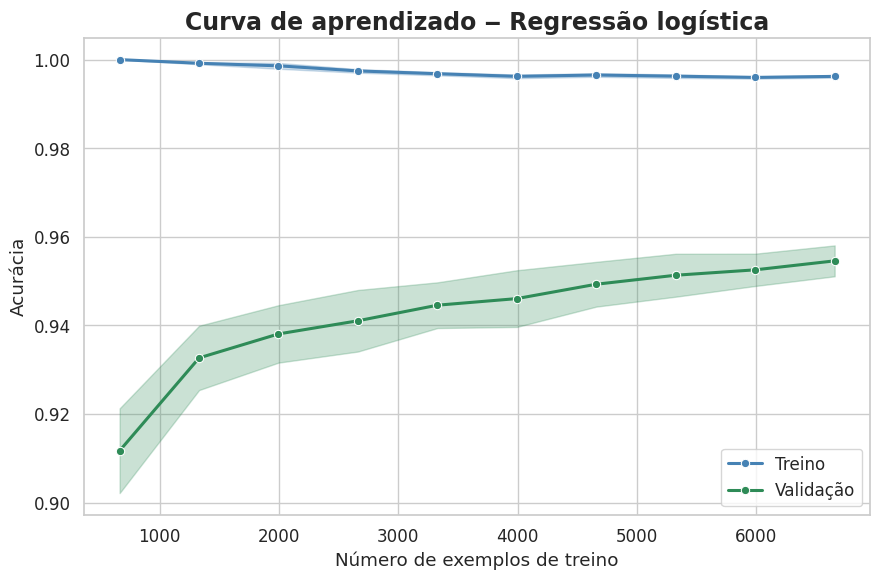

In [38]:
from sklearn.model_selection import learning_curve      # ou LearningCurveDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np


# Vamos calcular os resultados de treinamento e validação
train_sizes, train_scores, val_scores = learning_curve(
    estimator=modelo,
    X=X_treino,
    y=y_treino,
    cv=10,                               # k-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
    n_jobs=-1                           # usa todos os núcleos
)


# Estatísticas
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# Figura
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9, 6))

# Curva de Treinamento
sns.lineplot(
    x=train_sizes, y=train_mean,
    marker="o", linewidth=2.2,
    color="steelblue", label="Treino"
)
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.25, color="steelblue"
)

# Curva de validação
sns.lineplot(
    x=train_sizes, y=val_mean,
    marker="o", linewidth=2.2,
    color="seagreen", label="Validação"
)
plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.25, color="seagreen"
)

# Plotando
plt.title("Curva de aprendizado ‒ Regressão logística", fontsize=17, weight="bold")
plt.xlabel("Número de exemplos de treino")
plt.ylabel("Acurácia")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

O modelo apresenta uma melhora dos resultados até mais ou menos 5000 observações, estagnando no banco de validação após isso. Vamos tentar recuperar a probabilidade que o modelo atribuiu a cada tweet no banco de teste.

In [39]:
probs = modelo.predict_proba(X_teste) # Pegar as probabilidades estimadas no banco de teste

pd.DataFrame( # Colocar isso em um dataset
    probs,
    columns=["Prob_classe_0", "Prob_classe_1"]
).head()

,Prob_classe_0,Prob_classe_1
0,0.082255,0.917745
1,0.590117,0.409883
2,0.000030,0.999970
3,0.000054,0.999946
4,0.044163,0.955837


In [40]:
# Pegar o texto original usando o index do Y de teste
original_text_test = df_rel.loc[y_teste.index, 'content']

# Criar um dataframe com o texto e as probabilidades
results_df = pd.DataFrame({
    'Original_Text': original_text_test,
    "Probabilidade Irrelevante": probs[:, 0],
    "Probabilidade Relevante": probs[:, 1]
})

# ver os resultados para as cinco primeiras observações
display(results_df[['Probabilidade Relevante', 'Original_Text']].head(5))

,Probabilidade Relevante,Original_Text
6317,0.917745,"Só no último ano, apresentei propostas para reduzir o preço dos combustíveis e alimentos, para acelerar a vacinação contra a COVID, para taxar os bilionários que enriqueceram na pandemia e para fortalecer a luta antirracista. Esses são os problemas centrais no Brasil!"
5714,0.409883,"O desgoverno gerou um prejuízo de R$ 37,3 milhões por causa da má gestão e por não se importar com o povo. Assim como foi com o tanto de ivermectina que perdeu a validade. Eles não se importam!"
7770,0.999970,"ESCÂNDALO! Documento da área técnica do TCU aponta ""indícios robustos"" de fraude em licitações de produção de cloroquina feitas no governo Bolsonaro. Roubaram vacina, roubaram cloroquina e mataram muita gente!"
4561,0.999946,O MGTV repercutiu a CPI dos fura-filas da vacinação. Hoje fui eleito presidente da CPI. Com muita responsabilidade vamos trabalhar para apurar todas as possíveis irregularidades na vacinação do Estado. \n\nAcompanhe a reportagem:\n\n
3918,0.955837,Queiroga: “Tenho procurado fortalecer o sistema de vacinação”.\n\nPelo jeito não tá achando... 🗺 🔍 \n#CPIdaPandemia


In [41]:
# Vamos ordenar pelas maiores probabilidades de ser Relevante
top_5_relevant_tweets = results_df.sort_values(by='Probabilidade Relevante', ascending=False).head(5)

display(top_5_relevant_tweets[['Probabilidade Relevante', 'Original_Text']])

,Probabilidade Relevante,Original_Text
8436,1.0,"#VacinaSim - Hoje chegou ao Amapá mais 25.720 doses de vacinas contra a Covid-19. São 13.200 doses da Coronavac, 8.190 doses da Pfizer e 4.330 doses da Janssen (dose única). Em breve a vacina estará ""nos braços"" dos amapaenses!??????"
3527,1.0,Confira a vacinação deste domingo (5):\n- 1ª dose: pessoas de 17+ anos; gestantes e puérperas de 12+ anos; e adolescentes de 12 a 17 anos com comorbidades.\n- 2ª dose: Coronavac com retorno até 7/9 e Oxford ou Pfizer até 25/9.\n- 3ª dose: idosos 80+ anos q tomaram 2ª dose até 16/3.
5286,1.0,"@yurividal @JairoGranadoAdv Os portadores de deficiência estão inclusos nessa fase, de comorbidades. Infelizmente, não temos vacinas suficientes para vacinar todos de uma vez, mas a vacinação vai seguir por este grupo. Reiteramos que o problema fundamental é o número reduzido de vacinas. #EquipeEd"
4157,1.0,"#ImunizaJáCuritiba\nCom a chegada de 52.685 novas doses de vacina (51.665 de Astrazeneca e 1.030 de Coronavac), conseguiremos completar a vacinação com primeira dose do grupo prioritário de idosos - acima de 60 anos. Mais tivermos, mais aplicaremos."
5663,1.0,"👶🏽💉 A vez deles chegou! A partir de amanhã (22), crianças de 6 meses a 2 anos COM COMORBIDADES já podem tomar a vacina contra a Covid em 18 pontos de vacinação do Município (confira os locais no card). 👇🏾\n\nA vacina é importante e a luta contra a Covid ainda não acabou! 💪🏽"


E agora as menores probabilidades

In [42]:
# Sort the results_df by 'Prob_classe_1' in descending order and select the top 5
top_5_relevant_tweets = results_df.sort_values(by='Probabilidade Irrelevante', ascending=False).head(5)

# Display the top 5 tweets and their probabilities
display(top_5_relevant_tweets[['Probabilidade Relevante', 'Original_Text']])

,Probabilidade Relevante,Original_Text
1087,0.000001,"O câncer de mama é o segundo que mais atinge mulheres no Amapá. De acordo com uma pesquisa do Instituto Nacional de Câncer (INCA) em 66,2% dos casos de câncer de mama, é a própria mulher quem detecta os primeiros sinais da doença. Por isso é tão importante o auto exame da mama!"
3007,0.000011,"Esse é o câncer que mais afeta a população masculina do nosso país, depois do câncer de pele não melanoma. No Brasil, um homem morre a cada 38 minutos devido ao câncer de próstata, segundo os dados mais recentes Inca. O diagnóstico precoce é fundamental! Faça a sua parte!"
6443,0.000065,"Hoje completa 8 meses da Chacina do Jacarezinho. Ontem, a mãe de uma das vítimas veio a falecer de câncer, que por conta da política pública de segurança genocida, teve seu quadro agravado. Toda solidariedade aos familiares e amigos!"
2900,0.000181,O @minsaude atualiza a situação do #coronavírus no Brasil - 17/05\n▶️241.080 casos confirmados\n▶️130.840 em acompanhamento\n▶️94.122 recuperados\n▶️16.118 óbitos\n ⏺️ 298 óbitos nos últimos 3 dias\n▶️2.450 óbitos em investigação\nSaiba mais: #COVID19
4740,0.000262,"Um mês após a chacina do Jacarezinho. Katlhen, uma jovem negra, com o filho na barriga, foi assassinada por uma bala do Estado. O governo do Rio de Janeiro e sua polícia são responsáveis e têm de ser punidos. Minha imensa solidariedade à família e aos amigos."


Dessa forma podemos ver exatamente o resultado que mostra Jurafsky et al. sobre o cálculo de probabilidades no contexto de uma regressão logística. Parece que tweets que mencionam juntamente doses e vacinas são atribuídos com grande probabilidade de serem relevantes, e são classificados como a classe 1. Já tweets que mencionam câncer ou a Chacina do Jacarezinho (presente pela palavra 'genocídio') tem baixíssimas probabilidades de serem relevantes, e são classificados como Irrelevantes.

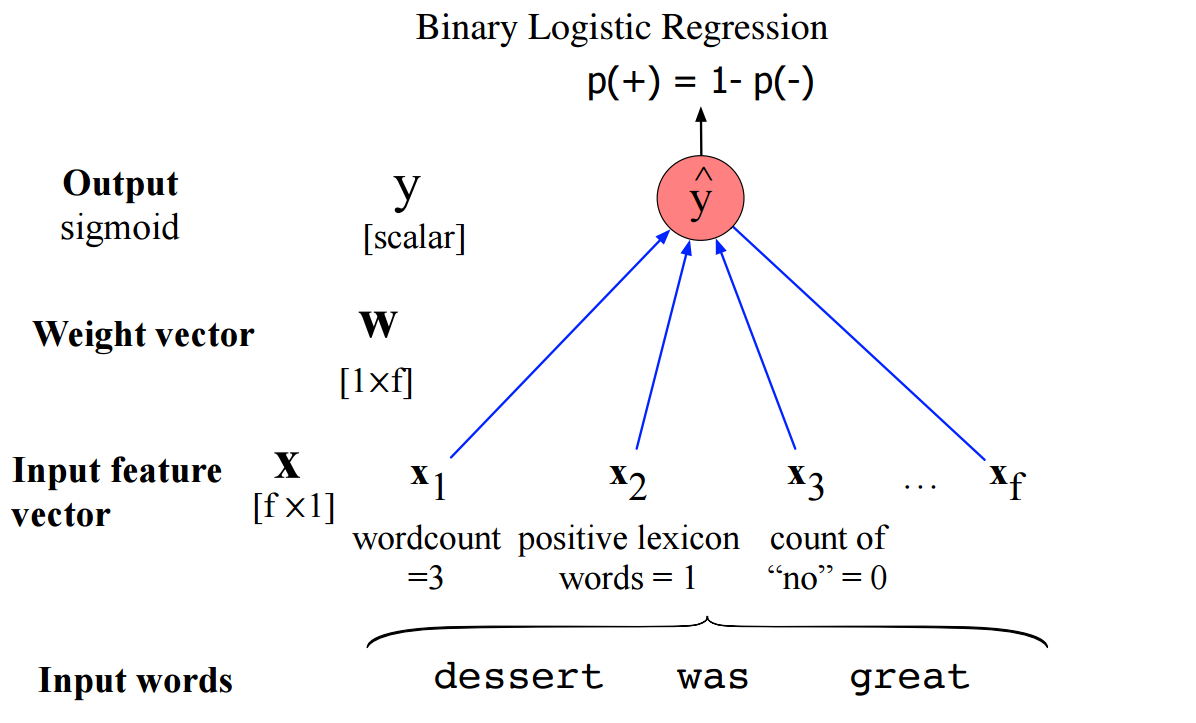

Vamos explorar um pouco mais esses resultados com nuvens de palavras por classe.

In [43]:
from wordcloud import WordCloud

# Texto original + probabilidades (ajuste nomes se necessário)
original_text_test = df_rel.loc[y_teste.index, "texto_processado"]

results_df = pd.DataFrame({
    "texto": original_text_test,
    "prob_irrelevante": probs[:, 0],
    "prob_relevante":   probs[:, 1]
})

# Separe por threshold
tweets_rel   = results_df.loc[results_df.prob_relevante   >= 0.50, "texto"] # Cortando para probabilidades maiores que 50% para Relevante
tweets_irrel = results_df.loc[results_df.prob_irrelevante >= 0.50, "texto"] # Cortando para probabilidades maiores que 50% para Irrelevante

txt_rel   = " ".join(tweets_rel)
txt_irrel = " ".join(tweets_irrel)

wc_args = dict(width=900, height=450, background_color="white", colormap="viridis")
wc_rel   = WordCloud(**wc_args).generate(txt_rel)
wc_irrel = WordCloud(**wc_args).generate(txt_irrel)

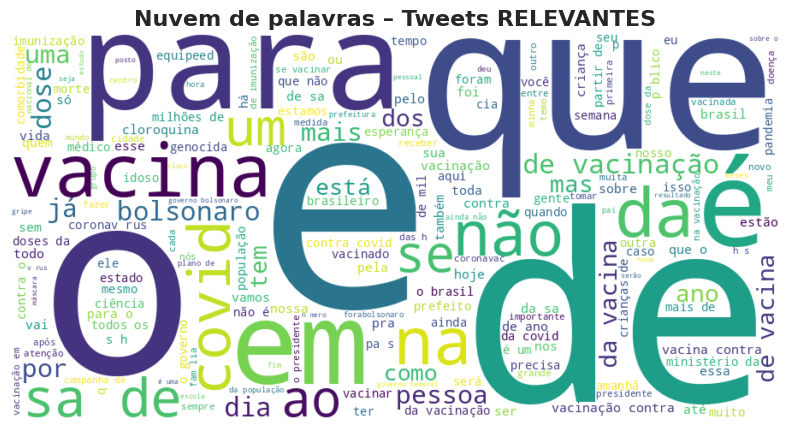

In [44]:
# Nuvem de palavras de tweets relevantes
tweets_rel = results_df.loc[results_df.prob_relevante >= 0.50, "texto"]
txt_rel    = " ".join(tweets_rel)

wc_rel = WordCloud(width=900, height=450,
                   background_color="white",
                   colormap="viridis").generate(txt_rel)

plt.figure(figsize=(10, 5))
plt.imshow(wc_rel, interpolation="bilinear")
plt.title("Nuvem de palavras – Tweets RELEVANTES", fontsize=16, weight="bold")
plt.axis("off")
plt.show()


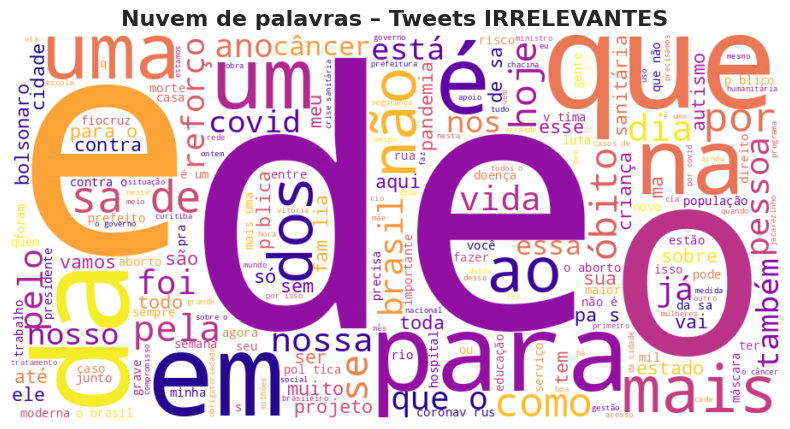

In [45]:
# Tweets Irrelevantes

tweets_irrel = results_df.loc[results_df.prob_irrelevante >= 0.50, "texto"]
txt_irrel    = " ".join(tweets_irrel)

wc_irrel = WordCloud(width=900, height=450,
                     background_color="white",
                     colormap="plasma").generate(txt_irrel)

plt.figure(figsize=(10, 5))
plt.imshow(wc_irrel, interpolation="bilinear")
plt.title("Nuvem de palavras – Tweets IRRELEVANTES", fontsize=16, weight="bold")
plt.axis("off")
plt.show()

Os tweets relevantes seguem a lógica esperada: mencionam diretamente vacinas, doses e a COVID-19. Já tweets irrelevantes contém tweets que apesar de conter algumas palavras que eram do interesse da pesquisa, como efeitos adversos da vacina (que causariam autismo, câncer, aborto, etc), não se referem de fato às vacinas de COVID-19. No entanto, as stopwords (e.g. para, de, e) atrapalham um pouco a visualização. Vamos refazer a figura sem elas, pois é o que o modelo realmente usou para treinamento.

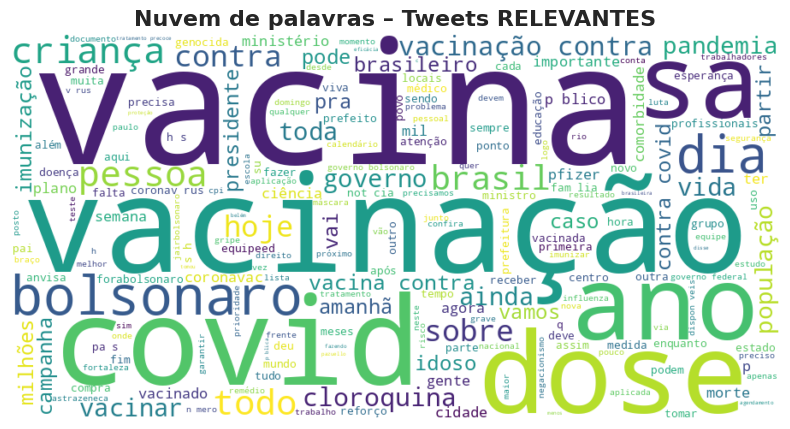

In [46]:
# 1) STOPWORDS DO NLTK (português)
pt_stop = set(stopwords.words("portuguese"))

# 2) OU LISTA CUSTOMIZADA (adicione/remova à vontade)
# pt_stop = {
#     "a","ao","aos","as","de","do","da","das","dos","e","em","entre","o","os","que",
#     "com","por","para","como","mais","muito","não","já","se","sem","sobre","sua",
#     "seu","são","ser","foi","era","dos","das","este","essa","isso","isto",
# }


tweets_rel = results_df.loc[results_df.prob_relevante >= 0.50, "texto"]
txt_rel    = " ".join(tweets_rel)

wc_rel = WordCloud(
    width=900,
    height=450,
    background_color="white",
    colormap="viridis",
    stopwords=pt_stop          # <<< AQUI EXCLUÍMOS AS STOPWORDS
).generate(txt_rel)

plt.figure(figsize=(10, 5))
plt.imshow(wc_rel, interpolation="bilinear")
plt.title("Nuvem de palavras – Tweets RELEVANTES", fontsize=16, weight="bold")
plt.axis("off")
plt.show()

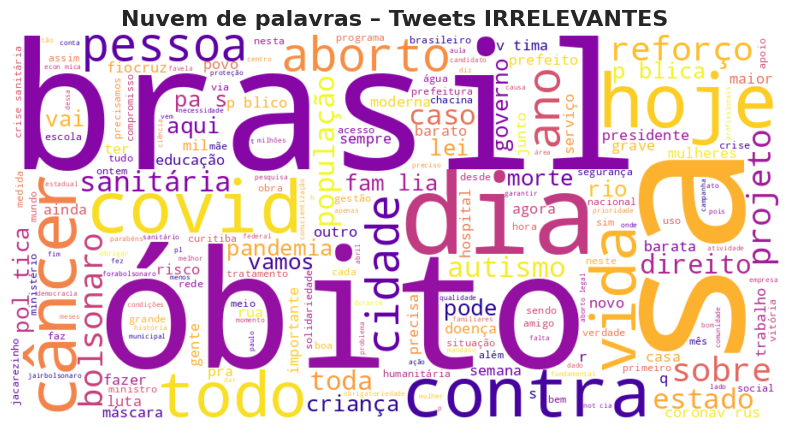

In [47]:

wc_irrel = WordCloud(
    width=900,
    height=450,
    background_color="white",
    colormap="plasma",
    stopwords=pt_stop          # <<< remove as stopwords
).generate(txt_irrel)

plt.figure(figsize=(10, 5))
plt.imshow(wc_irrel, interpolation="bilinear")
plt.title("Nuvem de palavras – Tweets IRRELEVANTES", fontsize=16, weight="bold")
plt.axis("off")
plt.show()

Agora sim conseguimos ver com mais clareza o que está acontecendo: Nos textos relevantes, as principais palavras são "Vacinação, vacina, dose e covid". No irrelevante, covid aparece, mas parece que são tweets mais sobre óbitos, número de casos, etc. Com isso, conseguimos ter uma ideia mais substantiva por trás das escolhas do modelo.